# Necessary imports

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import *
from grid_cell_utilities import *
from ripser import ripser
import umap
import plotly.express as px

# Load data

In [2]:
# Load grid cells
with open('data_files/GridCellDictionary3June2025.pkl', 'rb') as file:
    GridCellDictionary = pickle.load(file)

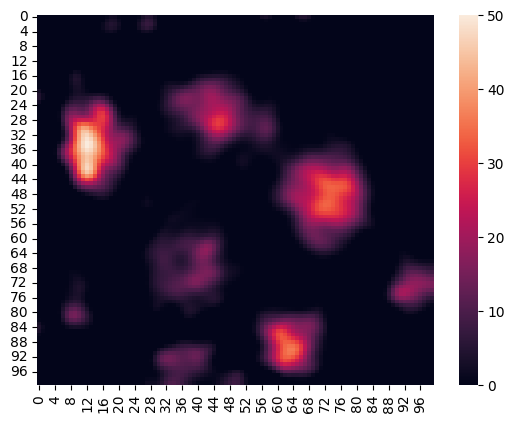

In [3]:
# Plot a sample grid cell

sns.heatmap(GridCellDictionary[50]['fully_processed_rate_map'])
plt.show()

In [4]:
# Get a sample of grid cells

grid_cell_samples = sample_grid_cell_dictionary(GridCellDictionary, [0, 0, 0, 0, 180])

In [5]:
# Construct rate map tensors

num_neurons = len(grid_cell_samples)
rate_map_tensor = np.zeros((100, 100, num_neurons))

for list_index, neuron_index in enumerate(grid_cell_samples):
    rate_map = GridCellDictionary[neuron_index]['fully_processed_rate_map']
    rate_map_tensor[:, :, list_index] = rate_map

In [6]:
# Simulate a walk in a square enclosure

sample_walk = make_standard_walk_in_square_enclosure(100000, -.7, .7, -.7, .7)
sample_walk_as_matrix_indices = convert_walk_in_square_enclosure_to_list_of_matrix_indices(100000, sample_walk, -.7, .7, -.7, .7, 100, 100)

In [7]:
# Get grid cell responses

response_matrix = compute_grid_cell_response_given_rate_map_tensor_and_walk_as_matrix_indices(rate_map_tensor, sample_walk_as_matrix_indices)

# Do topology pipeline

In [8]:
# Get correlations and convert to dissimilarity matrix

corr_matrix = np.corrcoef(response_matrix)
corr_matrix = (corr_matrix - np.min(corr_matrix))/(np.max(corr_matrix) - np.min(corr_matrix))
dissim_mat = 1 - corr_matrix

In [9]:
# Do ripser calculation

result = ripser(dissim_mat, distance_matrix=True)
diagrams = result['dgms']

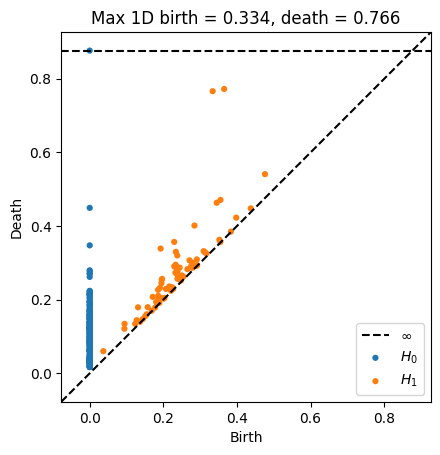

In [10]:
# Get Ripser info and plot persistene diagram

dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
# plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

In [11]:
def plot_n_longest_bars(array, n, title = None):
    # Sort the array based on the width of the bars (x_end - x_start)
    sorted_array = sorted(array, key=lambda x: x[1] - x[0], reverse=True)
    
    # Take the first n rows from the sorted array
    n_longest_bars = sorted_array[:n]

    # Sort by birthtime
    n_longest_bars = sorted(n_longest_bars, key = lambda x: x[0], reverse = True)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot each of the n longest bars
    for i in range(len(n_longest_bars)):
        x_start, x_end = n_longest_bars[i]
        width = x_end - x_start
        ax.hlines(i, x_start, x_end, linewidth=5, color='black')
    
    # Set plot limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, len(n_longest_bars))
    ax.set_xlabel('')
    ax.set_title('')
    
    # Hide y-axis ticks and labels
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Hide x-axis ticks and labels
    # ax.set_xticks([])
    # ax.set_xticklabels([])
    
    # Show grid lines
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')
    
    plt.xticks(np.arange(0, 1.1, 0.1))

    ax.set_title(title)
    
    # Show the plot
    plt.show()


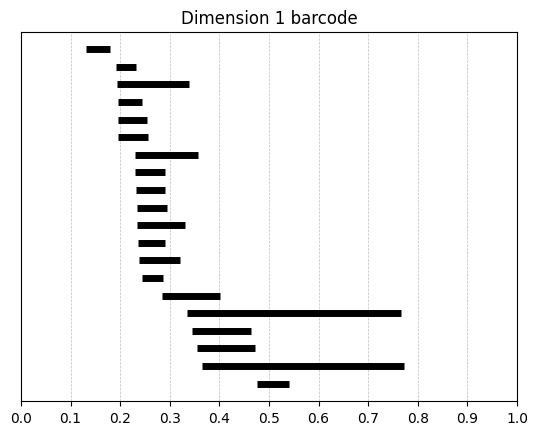

In [12]:
plot_n_longest_bars(diagrams[1], 20, title = 'Dimension 1 barcode')

# Do UMAP for comparison

In [13]:
reducer = umap.UMAP(n_neighbors=15, n_components=3, random_state=42)

In [14]:
embedding = reducer.fit_transform(dissim_mat)

/opt/homebrew/Caskroom/miniconda/base/envs/SIAMAG25/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
# Convert to Plotly-friendly format
fig = px.scatter_3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    title='3D UMAP Projection',
    opacity=0.7
)

fig.show()